In [1]:
import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import jax
from jax import vmap, jit
import jax.numpy as jnp
import jax.random as random

import numpyro
# from numpyro.contrib.hsgp.approximation import hsgp_squared_exponential
import numpyro.distributions as dist
from numpyro.infer import (
    MCMC,
    NUTS,
    init_to_feasible,
    init_to_median,
    init_to_sample,
    init_to_uniform,
    init_to_value,
    Predictive
)
from scipy.spatial.distance import  cdist


# matplotlib.use("Agg")  # noqa: E402
import arviz as az
import pymc as pm
# import pytensor.tensor as pt
import pymc_bart as pmb

from hsgb.approximation import hsgp_squared_exponential


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [28]:

# squared exponential kernel with diagonal noise term
@jit
def kernel(X,Xs, var, length, noise, jitter=1.0e-6, include_noise=True):
    delta_sq =  jnp.power(cdist(X, Xs, metric="euclidean") / length, 2.0)
    k = var * jnp.exp(-0.5 * delta_sq)
    if include_noise:
        k += (noise + jitter) * jnp.eye(delta_sq.shape[0])
    return k

@jax.jit
def rbf_kernel(X1, X2, var, length , noise, jitter=1.0e-6, include_noise=True):
    # Scale the inputs by the length scale
    X1_scaled = X1 / length
    X2_scaled = X2 / length
    # Compute squared norms
    X1_sq_norms = jnp.sum(X1_scaled**2, axis=1, keepdims=True)
    X2_sq_norms = jnp.sum(X2_scaled**2, axis=1, keepdims=True)
    # Compute squared distances using broadcasting
    sqdist = X1_sq_norms + X2_sq_norms.T - 2 * jnp.dot(X1_scaled, X2_scaled.T)
    # Compute the RBF kernel
    K = var * jnp.exp(-0.5 * sqdist)
    if include_noise:
        K += (noise + jitter) * jnp.eye(sqdist.shape[0])
    return K



def model(Xgp,Xlin, Y):
    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    # noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 10.0))
    noise = numpyro.sample("kernel_noise", dist.Exponential(1))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))

    # compute kernel
    k = rbf_kernel(Xgp,Xgp, var, length, noise)
    # k = kernel(Xgp,Xgp, var, length, noise)
    # k = kernel(Xgp,Xgp, var, length)
    L = jnp.linalg.cholesky(k)

    # f_x = numpyro.sample("f_x", dist.MultivariateNormal(loc=jnp.zeros(Y.shape[0]),
    #                                                               covariance_matrix = k))
    #                                                               scale_tril = L))
    # Linear part
    beta = numpyro.sample("beta",dist.Normal(0,5))
    
    mu = jnp.dot(Xlin,beta) 
    # mu = f_x
    # numpyro.sample("Y",dist.Normal(loc=mu,scale=noise),obs=Y)
    numpyro.sample("Y",dist.MultivariateNormal(
                                                # loc=jnp.zeros(Y.shape[0]),
                                                loc=mu,
                                               # covariance_matrix = k),
                                               scale_tril = L),
                                            obs=Y)
        
    # with numpyro.plate("n",Y.shape[0]):
    #     numpyro.sample("Y", dist.Normal(loc=mu,scale=noise), obs=Y)


def HSGB_GP_model(x_gp,x_lin,y, ell, m, non_centered=True):
    # --- Priors ---
    alpha = numpyro.sample("alpha", dist.InverseGamma(concentration=12, rate=10))
    length = numpyro.sample("length", dist.InverseGamma(concentration=6, rate=1))
    noise = numpyro.sample("noise", dist.InverseGamma(concentration=12, rate=10))
    # --- Parametrization ---
    f = hsgp_squared_exponential(
        x=x_gp, alpha=alpha, length=length, ell=ell, m=m, non_centered=non_centered
    )
    coef = numpyro.sample("coef",dist.Normal(0,5))
    mu = x_lin*coef + f
    # --- Likelihood ---
    with numpyro.plate("n", y.shape[0]):
        # numpyro.sample("likelihood", dist.Normal(loc=mu, scale=noise), obs=y)
        # numpyro.sample("Y", dist.Normal(loc=f, scale=noise), obs=y)
        numpyro.sample("Y", dist.Normal(loc=mu, scale=noise), obs=y)
        
        
# helper function for doing hmc inference
def run_inference(model, rng_key, Xgp, Xlin, Y):
    start = time.time()
    # demonstrate how to use different HMC initialization strategies
    # if args.init_strategy == "value":
    #     init_strategy = init_to_value(
    #         values={"kernel_var": 1.0, "kernel_noise": 0.05, "kernel_length": 0.5}
    #     )
    # elif args.init_strategy == "median":
    #     init_strategy = init_to_median(num_samples=10)
    # elif args.init_strategy == "feasible":
    #     init_strategy = init_to_feasible()
    # elif args.init_strategy == "sample":
    #     init_strategy = init_to_sample()
    # elif args.init_strategy == "uniform":
    #     init_strategy = init_to_uniform(radius=1)
    # kernel = NUTS(model, init_strategy=init_strategy)
    esti_kernel = NUTS(model, init_strategy=init_to_median(num_samples=10))
    mcmc = MCMC(
        esti_kernel,
        num_warmup=1000,
        num_samples=2000,
        num_chains=2,
        # thinning=2,
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    mcmc.run(rng_key, Xgp, Xlin, Y)
    mcmc.print_summary()
    print("\nMCMC elapsed time:", time.time() - start)
    return mcmc.get_samples()


# do GP prediction for a given set of hyperparameters. this makes use of the well-known
# formula for Gaussian process predictions
def predict(rng_key, Xgp, Y, Xgp_test, var, length, noise, use_cholesky=True):
    # compute kernels between train and test data, etc.
    # k_pp = kernel(Xgp_test, Xgp_test, var, length, noise, include_noise=False) # mXm
    k_pp = rbf_kernel(Xgp_test, Xgp_test, var, length, noise, include_noise=True) # mXm
    k_pX = rbf_kernel(Xgp_test, Xgp, var, length, noise, include_noise=False) # mXn
    k_XX = rbf_kernel(Xgp, Xgp, var, length, noise, include_noise=True) #nXn

    # since K_xx is symmetric positive-definite, we can use the more efficient and
    # stable Cholesky decomposition instead of matrix inversion
    if use_cholesky:
        K_xx_cho = jax.scipy.linalg.cho_factor(k_XX)
        K = k_pp - jnp.matmul(k_pX, jax.scipy.linalg.cho_solve(K_xx_cho, k_pX.T))
        mean = jnp.matmul(k_pX, jax.scipy.linalg.cho_solve(K_xx_cho, Y))
    else:
        K_xx_inv = jnp.linalg.inv(k_XX) #nXn
        K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX))) #mXm 
        mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y)) 
        # mean += np.dot(beta[:,np.newaxis],np.transpose(Xlin_test))
        
    # mean += np.dot(beta[:,np.newaxis], np.transpose(Xlin_test[:,np.newaxis]))
    sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.0)) * jax.random.normal(
        rng_key, X_test.shape[:1]
    )

    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean, mean + sigma_noise


# create artificial regression dataset
def get_data(N=150, sigma_obs=0.25):
    np.random.seed(0)
    # X = jnp.linspace(-1, 1, N)
    X = np.random.uniform(size=N, low=0, high=1)
    # X = np.sort(X,axis=0)
    X2 = np.random.uniform(size=N,low=-1,high=0)
    # X3 = np.random.binomial(n=1,p=0.5,size=N)
    # X2 = np.random.normal(size=N,loc=1,scale=1)
    # Y = X + 0.2 * jnp.power(X, 3.0) + 0.5 * jnp.power(0.5 + X, 2.0) * jnp.sin(4.0 * X)
    Y = 2*X + X2 + 4*np.exp(X2/2)
    # Y = X + 2*X2 + 0.2 * jnp.power(X, 3.0) + 0.5 * jnp.power(0.5 + X, 2.0)
    # Y += sigma_obs * np.random.randn(N)
    Y += sigma_obs * np.random.standard_normal(N)
    # Y -= jnp.mean(Y)
    # Y /= jnp.std(Y)

    # assert X.shape == (N,)
    # assert Y.shape == (N,)

    # X_test = np.random.uniform(size=N, low=-0.2, high=1.2)
    # X_test = np.sort(X_test, axis=0)
    # Y_test = X_test + 0.2 * jnp.power(X_test, 3.0) + 0.5 * jnp.power(0.5 + X_test, 2.0) * jnp.sin(4.0 * X_test)
    # Y_test += sigma_obs * np.random.randn(N)
    X_t = np.random.uniform(size=N, low=-0.25, high=1.25)
    X2_t = np.random.uniform(size=N,low=-1.5,high=0)
    # X3_t = np.random.binomial(n=1,p=0.7,size=N)
    # X2_t = np.random.normal(size=N,loc=1,scale=1)
    # Y = X + 0.2 * jnp.power(X, 3.0) + 0.5 * jnp.power(0.5 + X, 2.0) * jnp.sin(4.0 * X)
    # Y_t = X_t + 2*X2_t + 0.2 * np.power(X_t, 3.0) + 0.5 * np.power(0.5 + X_t, 2.0)
    # Y_t = X2_t + np.power(X2,2) + 0.5*np.power(0.5 + X_t, 2.0)*jnp.sin(4*X_t)
    # Y_t = 2*X3_t + 1.5*X_t + X2_t + 2*X_t*X2_t + 0.5*np.exp(2*X_t)
    Y_t =  2*X_t + X2_t + 4*np.exp(X2_t/2)
    # Y_t = X_t + 2*X2_t + 0.2 * jnp.power(X_t, 3.0) + 0.5 * jnp.power(0.5 + X_t, 2.0)
    # Y_t += sigma_obs * np.random.randn(N)
    Y_t += sigma_obs * np.random.standard_normal(N)
    # Y -= jnp.mean(Y)
    # Y /= jnp.std(Y)

    # return np.transpose(np.array([X,X2])), Y, np.transpose(np.array([X_t,X2_t])), Y_t
    return X, X2, Y, X_t, X2_t, Y_t



In [36]:
# DATA

# X, Y, X_test = get_data(N=args.num_data)
X, X2, Y, X_test, X2_test, Y_test = get_data()

Xgp = X2[:,jnp.newaxis]
Xlin = X[:,jnp.newaxis]

Xgp_t = X2_test[:,jnp.newaxis]
Xlin_t = X_test[:,jnp.newaxis]

Xgp_test = X2_test[:,np.newaxis]

# Xarr = np.transpose(np.array([X,X2]))
Xarr = jnp.transpose(jnp.array([X2]))
# Xarr_tst = np.transpose(np.array([X_test,X2_test]))
Xarr_tst = jnp.transpose(jnp.array([X2_test]))

# X2c = X2 - X2.mean()
# X2c_test = X2_test - X2_test.mean()

print(Xgp.shape, Xlin.shape, Y.shape)
print(Xgp_t.shape, Xlin_t.shape, Y.shape)
print(Xarr[:,1:].shape, Y.shape)
print(Xarr_tst.shape, Y_test.shape)


(150, 1) (150, 1) (150,)
(150, 1) (150, 1) (150,)
(150, 0) (150,)
(150, 1) (150,)


In [25]:
# Sparse GP in PYMC
with pm.Model(coords={"basis_coeffs": np.arange(200), "obs_id": np.arange(len(Y))}) as gp_model:
    # Set mutable data
    X_gp = pm.ConstantData("X_gp", Xgp)
    X_fe = pm.ConstantData("X_fe", X_test)

    # GP priors
    ell = pm.Lognormal("ell",mu=0,sigma=10)
    alpha = pm.Lognormal("alpha",mu=0,sigma=10)
    
    cov_func = alpha**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell)
    m0, c = 100, 2.5
    # parametrization = "centered"
    gp = pm.gp.HSGP(m=[m0], c=c, cov_func=cov_func)
    f_x = gp.prior("f", X=X_gp)    
    # Priors on regression coefficients
    
    beta = pm.Normal("beta", mu=0.0, sigma=10.0, shape=2)
    mu = beta[0] + beta[1]*X_fe + f_x
    sigma = pm.HalfNormal("sigma", 0.5)
    pm.Normal("y_obs", mu=mu, sigma=sigma, observed=Y, dims="obs_id")

    # idata = pm.sample_prior_predictive()
    idata = pm.sample()
    idata.extend(pm.sample_posterior_predictive(idata))
# pm.model_to_graphviz(gp_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ell, alpha, f_hsgp_coeffs_, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 4000 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y_obs]


In [26]:
az.summary(idata, round_to=2)


C:\Users\bar21\.conda\envs\STAT\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
f_hsgp_coeffs_[0],0.19,0.45,-0.42,0.65,0.22,0.17,4.03,4.03,31633592.87
f_hsgp_coeffs_[1],0.51,0.37,0.08,0.94,0.18,0.14,4.03,4.03,31633592.87
f_hsgp_coeffs_[2],-0.60,0.17,-0.78,-0.35,0.08,0.06,4.03,4.03,31633592.87
f_hsgp_coeffs_[3],-0.03,0.57,-0.98,0.42,0.28,0.22,4.03,4.03,31633592.87
f_hsgp_coeffs_[4],-0.46,0.39,-0.87,0.17,0.19,0.15,4.03,4.03,31633592.87
...,...,...,...,...,...,...,...,...,...
f[145],0.00,0.00,0.00,0.00,0.00,0.00,4000.00,4000.00,NaN
f[146],0.00,0.00,0.00,0.00,0.00,0.00,4000.00,4000.00,NaN
f[147],0.00,0.00,0.00,0.00,0.00,0.00,4000.00,4000.00,NaN
f[148],0.00,0.00,0.00,0.00,0.00,0.00,4000.00,4000.00,NaN


In [31]:
sampler = NUTS(HSGB_GP_model)
mcmc = MCMC(sampler=sampler, num_warmup=1000, num_samples=2000, num_chains=2)

rng_key = random.PRNGKey(seed=42)
rng_key, rng_subkey = random.split(rng_key)

ell = 1.3
m = 50
non_centered = True

mcmc.run(rng_subkey, X2c, X,Y, ell, m, non_centered)

C:\Users\bar21\AppData\Local\Temp\ipykernel_15740\2195580313.py:2: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(sampler=sampler, num_warmup=1000, num_samples=2000, num_chains=2)
sample: 100%|██████████| 3000/3000 [00:04<00:00, 709.63it/s, 20 steps of size 2.92e-02. acc. prob=0.91] 


In [32]:
idata = az.from_numpyro(posterior=mcmc)

az.summary(
    data=idata,
    var_names=["alpha", "length", "noise","coef", "beta"],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.511,0.419,0.807,2.284,0.022,0.016,417.0,234.0,1.01
length,0.202,0.014,0.177,0.219,0.001,0.001,295.0,443.0,1.00
noise,0.263,0.016,0.233,0.294,0.001,0.001,337.0,716.0,1.01
coef,1.930,0.079,1.787,2.084,0.004,0.003,472.0,724.0,1.01
beta[0],3.473,0.604,2.284,4.539,0.036,0.026,297.0,246.0,1.01
beta[1],-1.164,0.633,-2.374,0.080,0.031,0.022,410.0,435.0,1.01
beta[2],-0.718,0.755,-2.224,0.693,0.041,0.029,342.0,260.0,1.00
beta[3],0.709,0.732,-0.720,2.132,0.034,0.026,468.0,418.0,1.01
beta[4],-0.881,0.633,-2.163,0.268,0.034,0.024,346.0,451.0,1.01
beta[5],0.282,0.650,-1.028,1.408,0.030,0.021,472.0,629.0,1.01


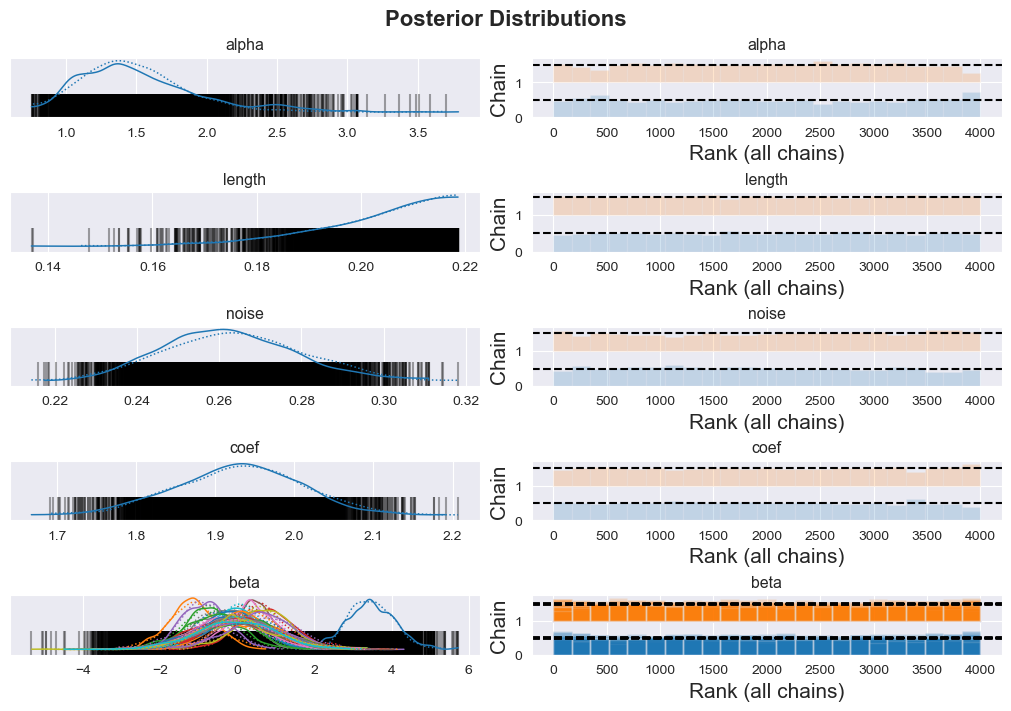

In [27]:
axes = az.plot_trace(
    data=idata,
    var_names=["alpha", "length", "noise","coef", "beta"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 7), "layout": "constrained"},
)
plt.gcf().suptitle("Posterior Distributions", fontsize=16, fontweight="bold");

In [39]:
predictive = Predictive(HSGB_GP_model, mcmc.get_samples())
posterior_predictive = predictive(rng_subkey, X2c_test, X_test,Y_test, ell, m, non_centered)
rng_key, rng_subkey = random.split(rng_key)

idata.extend(az.from_numpyro(posterior_predictive=posterior_predictive))

IndexError: index 16 is out of bounds for axis 0 with size 1

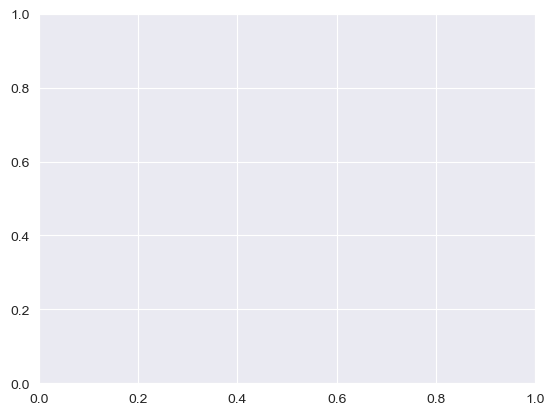

In [46]:
sorted_indices = np.argsort(X2c)
sorted_indices_t = np.argsort(X2c_test)


fig, ax = plt.subplots()
# ax.axvline(x=0, color="C2", alpha=0.8, linestyle="--", linewidth=2)
# ax.axvline(
#     x=1, color="C2", linestyle="--", alpha=0.8, linewidth=2, label="training range"
# )
az.plot_hdi(
    X2c_test[sorted_indices],
    idata.posterior_predictive["Y"][sorted_indices],
    hdi_prob=0.94,
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.1, "label": "$94\\%$ HDI (test)"},
    ax=ax,
)
az.plot_hdi(
    X2c_test[sorted_indices_t],
    idata.posterior_predictive["Y"][sorted_indices_t],
    hdi_prob=0.5,
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.3, "label": "$50\\%$ HDI (test)"},
    ax=ax,
)
# ax.plot(
#     X2c_test[sorted_indices_t],
#     idata.posterior_predictive["Y"].mean(dim=("chain", "draw"))[sorted_indices_t],
#     color="C1",
#     linewidth=3,
#     label="posterior predictive mean (test)",
# )
ax.scatter(X2c, Y[sorted_indices], c="C0", label="observed (train)")
ax.scatter(X2c_test, Y_test[sorted_indices_t], c="C1", label="observed (test)")
ax.plot(X2c, Y, color="black", linewidth=3, alpha=0.7, label="mean (latent)")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
ax.set(xlabel="x", ylabel="y")
ax.set_title("Posterior Predictive", fontsize=16, fontweight="bold");

In [44]:
idata.posterior_predictive

<xarray.Dataset> Size: 2MB
Dimensions:  (chain: 1, draw: 4000, Y_dim_0: 150)
Coordinates:
  * chain    (chain) int32 4B 0
  * draw     (draw) int32 16kB 0 1 2 3 4 5 6 ... 3994 3995 3996 3997 3998 3999
  * Y_dim_0  (Y_dim_0) int32 600B 0 1 2 3 4 5 6 ... 143 144 145 146 147 148 149
Data variables:
    Y        (chain, draw, Y_dim_0) float32 2MB 3.279 5.097 5.88 ... 2.548 2.522
Attributes:
    created_at:                 2024-06-04T11:45:37.403110
    arviz_version:              0.17.0
    inference_library:          numpyro
    inference_library_version:  0.14.0

In [37]:
# do inference
rng_key, rng_key_predict = random.split(random.PRNGKey(0))
samples = run_inference(model, rng_key, Xgp, Xlin, Y)


C:\Users\bar21\AppData\Local\Temp\ipykernel_9548\1353184751.py:97: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 3000/3000 [01:39<00:00, 30.24it/s, 7 steps of size 5.05e-01. acc. prob=0.91] 



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
           beta      4.37      0.31      4.36      3.87      4.86   3057.82      1.00
  kernel_length      1.33      0.07      1.33      1.22      1.44   1939.21      1.00
   kernel_noise      0.33      0.00      0.33      0.33      0.34   3774.67      1.00
     kernel_var      6.28      0.72      6.23      5.13      7.44   1944.99      1.00

Number of divergences: 0

MCMC elapsed time: 219.70766305923462


In [79]:
    # print(samples['beta'][:,np.newaxis].shape)
# print(np.transpose(X2_test[:,np.newaxis]).shape)
# print(np.dot(samples['beta'][:,np.newaxis],np.transpose(X2_test[:,np.newaxis])).shape)

KeyError: 'beta'

In [44]:
vmap_args = (
    random.split(rng_key_predict, samples["kernel_var"].shape[0]),
    samples["kernel_var"],
    samples["kernel_length"],
    samples["kernel_noise"],
    # samples["beta"],
)

vmap_args

(Array([[3857640471, 1326689894],
        [1197535223, 1119874629],
        [4190176587, 1415886299],
        ...,
        [2148928592, 2534147783],
        [2593304517,   36270637],
        [1999028389, 1895145348]], dtype=uint32),
 Array([6.39359  , 5.8441834, 5.8253546, ..., 5.1185517, 5.0679874,
        5.58865  ], dtype=float32),
 Array([1.3225474, 1.3280181, 1.3663857, ..., 1.2243301, 1.1786467,
        1.2774446], dtype=float32),
 Array([0.33180824, 0.33452052, 0.33456752, ..., 0.32924226, 0.3285693 ,
        0.33400542], dtype=float32))

In [38]:
# do prediction
vmap_args = (
    random.split(rng_key_predict, samples["kernel_var"].shape[0]),
    samples["kernel_var"],
    samples["kernel_length"],
    samples["kernel_noise"],
    # samples["beta"],
)
means, predictions = vmap(
    lambda rng_key, var, length, noise: predict(
        rng_key, Xgp, Y, Xgp_t, var, length, noise, use_cholesky=True
    )
)(*vmap_args)



TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
The error occurred while tracing the function rbf_kernel at C:\Users\bar21\AppData\Local\Temp\ipykernel_9548\1353184751.py:10 for jit. This concrete value was not available in Python because it depends on the value of the argument include_noise.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [114]:
lin_pred = np.dot(samples['beta'][:,np.newaxis],np.transpose(X3_test[:,np.newaxis]))

means += lin_pred
predictions += lin_pred


In [115]:
mean_prediction = np.mean(means, axis=0)
percentiles = np.percentile(predictions, [2.5, 97.5], axis=0)
mean_percentiles = np.percentile(means, [2.5, 97.5], axis=0)

print(mean_prediction.shape, '\n',
      means.shape, 
    'mean:', np.mean(mean_prediction), '\n',
      'mean ytest', np.mean(Y_test), '\n',
      'mean lin_pred', np.mean(lin_pred), '\n',
      'perc mean:', np.percentile(means, [2.5, 97.5]), '\n',
      'perc:', np.percentile(predictions, [2.5, 97.5]), '\n',
      'rmse:', np.mean(np.power(mean_prediction - Y_test,2))) 


(150,) 
 (4000, 150) mean: 4.50788 
 mean ytest 2.3724102412687276 
 mean lin_pred 1.3584474298556646 
 perc mean: [-0.68139954  7.92929771] 
 perc: [-0.71212576  7.96811142] 
 rmse: 12.220756


In [118]:
matplotlib.use('Qt5Agg')

# make plots
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

# plot training data
# ax.scatter(X_test.flatten(), Y_test, c=X2_test, cmap = "prism")
ax.scatter(X_test.flatten(), Y_test-np.mean(lin_pred,axis=0))
# plot 90% confidence level of predictions
# ax.fill_between(X_test.flatten(), percentiles[0,:], percentiles[1,:], color="lightblue")
# ax.fill_between(X_test.flatten(), mean_percentiles[0, :], mean_percentiles[1, :], color="lightblue")
# plot mean prediction
# ax.scatter(X_test.flatten(), mean_prediction, c="red")
ax.scatter(X_test.flatten(), mean_prediction-np.mean(lin_pred,axis=0), c="red")
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 95% CI")
plt.show()

# plt.savefig("gp_plot.pdf")
# plt.savefig("gp_plot2.pdf")

In [119]:
# make plots
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

# plot training data
# ax.scatter(X_test.flatten(), Y_test, c=X2_test, cmap = "prism")
ax.scatter(X2_test.flatten(), Y_test)
# plot 90% confidence level of predictions
# ax.fill_between(X_test.flatten(), percentiles[0,:], percentiles[1,:], color="lightblue")
# ax.fill_between(X_test.flatten(), mean_percentiles[0, :], mean_percentiles[1, :], color="lightblue")
# plot mean prediction
# ax.scatter(X_test.flatten(), mean_prediction, c="red")
ax.scatter(X2_test.flatten(), mean_prediction, c="red")
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 95% CI")
plt.show()


In [109]:
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

# plot training data
# ax.scatter(X_test.flatten(), Y_test, c=X2_test, cmap = "prism")
ax.scatter(X2_test.flatten(), Y_test)
# plot 90% confidence level of predictions
# ax.fill_between(X_test.flatten(), percentiles[0,:], percentiles[1,:], color="lightblue")
# ax.fill_between(X_test.flatten(), mean_percentiles[0, :], mean_percentiles[1, :], color="lightblue")
# plot mean prediction
# ax.scatter(X_test.flatten(), mean_prediction, c="red")
ax.scatter(X2_test.flatten(), mean_prediction, c="red")
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 95% CI")
plt.show()

In [25]:
with pm.Model() as full_model:
    # Xb = pm.Data("Xb",Xarr[:,0:1])
    # Xl = pm.Data("Xl",Xarr[:,1:2])
    with pm.Model() as bart_model:
        # Assuming pmb.BART is the function to create the BART prior
        f_Z = pmb.BART("f_Z", X=Xarr, Y=Y, m=20)
    # beta = pm.Normal("beta",mu=0, sigma=10)
    # mu = Xl*beta + mu_b
    # mu = pm.math.dot(X,beta) + f_Z
    mu = pm.math.dot(f_Z, X)
    sigma =  pm.HalfNormal("sigma", 0.5)
    pm.Normal("Y", mu=mu,sigma=sigma, observed=Y)
    full_model = pm.sample() 
    full_model.extend(pm.sample_posterior_predictive(full_model))
    

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>PGBART: [f_Z]
>NUTS: [sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 171 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [Y]


Output()

150